# Exploration 8

## 데이터 불러오기

In [2]:
import urllib.request
import pandas as pd
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
47723,Man stops train from running over injured comm...,A 26-year-old Mumbai man stood on a railway tr...
25755,Microsoft working on an Android-powered smartp...,Technology major Microsoft is working on a new...
89464,"He was very good boy, my only one: Martyred so...",Indian Army soldier Ummer Fayaz's father Fayaz...
39259,"8 MP forest officials held for killing man, bu...",Eight forest department personnel were arreste...
17085,Amazon probes claims of employees leaking data...,Amazon is investigating allegations that some ...
84629,McDonald's ends Olympic Games sponsorship afte...,McDonald's ended its 41-year-old sponsorship o...
15199,Wife and I went for film same day after cancer...,Actor Ayushmann Khurrana has revealed that aft...
39648,I'll call govt 'ek paise wali sarkar': Jyotira...,After the government cut the fuel price by 1 p...
75196,India capable of tackling any security challen...,"Prime Minister Narendra Modi on Tuesday said, ..."
81058,Uttarakhand witnessed maximum number of protes...,Uttarakhand had witnessed the maximum number o...


추상적 요약: text -> 본문
             headlines -> 요약된 데이터

추출적 요약: text열만 사용

## 데이터 전처리하기 (추상적 요약)

필요 모듈 및 전처리 모듈

In [4]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [6]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


### 데이터 정리하기

중복샘플, Null값이 존재하는 샘플 제거

중복 확인

In [7]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


중복 제거

In [8]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


Null값 확인

In [9]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


### 덱스트 정규화의 불용어 제거

In [10]:
# 참고: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
# 참고 링크를 썼더니 117개, LMS코드블록은 120개가 나와서 LMS 코드 블록을 사용하였다.

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


### 불용어 제거

In [11]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [12]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [13]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headlines:", preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
headlines: great way to start the day


본격적인 전처리

In [14]:
clean_text = []
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

headlines 전처리는 불용어 제거를 수용하지 않기 때문에 Flase

In [15]:
clean_summary = []
# 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_summary.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_summary[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


### 훈련데이터와 테스트 데이터 나누기

샘플의 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 91
텍스트의 평균 길이 : 58.23813542090281
요약의 최소 길이 : 1
요약의 최대 길이 : 18
요약의 평균 길이 : 9.553660024400163


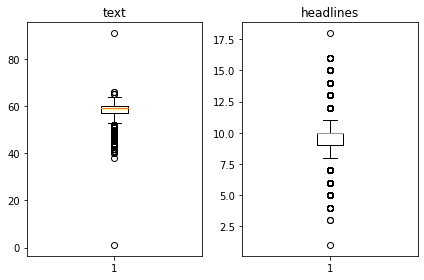

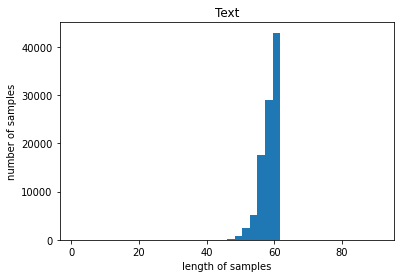

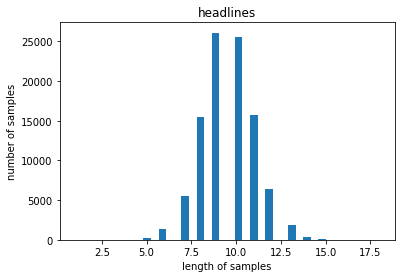

In [16]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

임의의 길이 정하기

In [17]:
text_max_len = 60
headlines_max_len = 11

In [18]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [19]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 0.997448149654331
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9121492476616511


정해진 길이보다 길면 제외

In [20]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 89498


In [21]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,sostoken New Zealand end Rohit Sharma-led Indi...,New Zealand end Rohit Sharma-led India's 12-ma...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",sostoken Aegon life iTerm insurance plan helps...,Aegon life iTerm insurance plan helps customer...
5,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...,sostoken Rahat Fateh Ali Khan denies getting n...,Rahat Fateh Ali Khan denies getting notice for...
9,"Cong wins Ramgarh bypoll in Rajasthan, takes t...",Congress candidate Shafia Zubair won the Ramga...,sostoken Cong wins Ramgarh bypoll in Rajasthan...,"Cong wins Ramgarh bypoll in Rajasthan, takes t..."
10,UP cousins fed human excreta for friendship wi...,Two minor cousins in Uttar Pradesh's Gorakhpur...,sostoken UP cousins fed human excreta for frie...,UP cousins fed human excreta for friendship wi...


In [22]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

이제 훈련데이터/테스트데이터 분리

encoder_input이 크기와 형태가 같은 순서가 섞인 정수 시퀀스 만들기

In [23]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[15432 47546 10271 ... 62192  9734 61136]


시퀀스를 이용하여 다시 데이터의 샘플 순서를 정의해주어 잘 섞인 샘플을 만든다

In [24]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

전체 데이터에 0.2를 곱하여 테스스 테이터의 크기를 정의해준다.

In [25]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 17899


정의한 개수를 이용해 전체 데이터를 양분

In [26]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 71599
훈련 레이블의 개수 : 71599
테스트 데이터의 개수 : 17899
테스트 레이블의 개수 : 17899


### 정수 인코딩

단어 집합(vocabulary)

In [27]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

등장 빈도수 확인

In [28]:
threshold = 9
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 87979
등장 빈도가 8번 이하인 희귀 단어의 수: 67298
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20681
단어 집합에서 희귀 단어의 비율: 76.49325407199446
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4428764150390054


- threshold를 7,8,9,10,11 각각 넣어보아도, 등장빈도 비율이 4% 내외였습니다. 저 높은게 좋을지 낮은게 좋을지는 잘 모르겠지만 최대한 LMS 노드와 비율을 맞춰주는것이 정확도를 높혀줄 것 같아 약 3.5%인 threshold = 9 를 텍하였습니다

단어집합에서 희귀단어를 제외할 경우 집합의 크기는 약 20000개 이므로, 20000으로 제한.

In [29]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

이제 20000이 넘는 숫자들은 인코딩 후에 데이터가 존재하지 않는다.

In [30]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[36, 244, 67, 51, 6, 517, 51, 1007, 1845, 452, 7, 1603, 755, 6, 326, 3, 709, 4, 3198, 7, 11902, 107, 2, 1342, 9, 43, 2697, 1, 1845, 10, 1, 417, 6221, 535, 8, 2728, 3, 1322, 403, 2687, 82, 21, 2677, 29, 3491, 837, 55, 874, 1, 661, 51, 2, 387, 5, 80, 19480, 9528, 1007, 1845, 2790, 4, 378, 1388], [3, 113, 3, 4905, 18471, 128, 9, 1715, 1031, 4222, 2751, 4789, 1862, 2422, 79, 32, 3, 796, 388, 133, 128, 2375, 331, 1, 293, 7, 206, 184, 375, 479, 45, 26, 29, 324, 3843, 7, 1715, 1539, 487, 567, 21, 12, 248, 333, 11, 131, 34, 2751, 1862, 4, 215, 1, 405, 6, 16104, 32, 7, 310, 15, 142], [151, 3899, 273, 8, 10, 11, 44, 2791, 92, 685, 1, 2231, 11, 44, 14888, 16, 1, 90, 203, 45, 219, 3456, 2231, 3900, 2628, 45, 4638, 752, 21, 2960, 45, 576, 157, 45, 489, 1195, 7, 515, 92, 138, 16105, 89, 1195, 82, 265, 45, 462, 92, 104, 45, 462, 38, 1401, 44, 33]]


토크나이저를 사용하여 `decoder_input_train`을 입력으로 전체 단어집합과 각단어의 빈도수를 계산한다.

In [31]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

등장 빈도수 비중 확인하기

In [32]:
threshold = 5
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 39491
등장 빈도가 4번 이하인 희귀 단어의 수: 27290
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 12201
단어 집합에서 희귀 단어의 비율: 69.10435289053201
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.835999910048508


- threshold rk 5일 경우가 집합에서 약 69%이지만, 등장 빈도는 약 5.8 밖에 되지 않으므로 제거. 12000 단어집합 크기로 제한합니다.

In [33]:
tar_vocab = 12000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 116, 47, 367, 948, 1269, 7, 1463, 569, 7, 6489, 79], [1, 276, 3679, 7, 34, 2730, 1679, 34, 667], [1, 1587, 105, 1116, 18, 2412, 32, 2118, 8, 18, 56, 2463], [1, 69, 45, 449, 4974, 1543, 73, 4, 2119], [1, 1680, 400, 44, 78, 6, 5370, 3, 1288, 2228, 1038]]
target
decoder  [[116, 47, 367, 948, 1269, 7, 1463, 569, 7, 6489, 79, 2], [276, 3679, 7, 34, 2730, 1679, 34, 667, 2], [1587, 105, 1116, 18, 2412, 32, 2118, 8, 18, 56, 2463, 2], [69, 45, 449, 4974, 1543, 73, 4, 2119, 2], [1680, 400, 44, 78, 6, 5370, 3, 1288, 2228, 1038, 2]]


패딩 전, 요약 길이가 0인 값 찾기

In [34]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 71599
훈련 레이블의 개수 : 71599
테스트 데이터의 개수 : 17899
테스트 레이블의 개수 : 17899


#### 패딩하기

- 저번 NLP에서는 뒤의 단어를 바탕으로 하기에 pre 가 좋았었다고 했는데, 이번데이터는 뒤가 아닌 각 요소들이 중요하다 생각되어  post로 뒤에 패딩을 하였다.

In [35]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## 어텐션 메커니즘 사용하기 (추상적 요약)

### 모델 설계하기

인코더 설계

In [36]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

디코더 설계

In [37]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

### 어텐션 메커니즘

In [38]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 60, 128)      2560000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 60, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

### EarlyStopping을 이용해 모델 훈련하기

In [41]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=512, callbacks=[es], epochs=2)

Epoch 1/2
140/140 [==============================] - 2286s 16s/step - loss: 6.0913 - val_loss: 5.8248
Epoch 2/2
140/140 [==============================] - 2265s 16s/step - loss: 5.7649 - val_loss: 5.5733


훈련데이터의 손실과, 검증데이터의 손실이 줄어드는 과정을 시각화

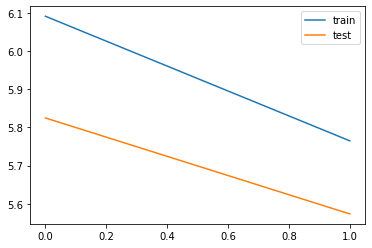

In [42]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 인퍼런스 모델 구현

In [43]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음


In [44]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [45]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [46]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 실제 결과와 요약문 비교하기 (추상적 요약)

### 모델 테스트하기

In [47]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [48]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : a delegation of the taliban militant group held talks with us diplomat in qatar on friday to discuss ways to end the war in afghanistan in the first confirmed meeting between the two parties the taliban maintains a political office in qatar the militant group reiterated that the us' presence in afghanistan was a big obstacle to peace 
실제 요약 : taliban holds talks with us in first confirmed meeting 
예측 요약 :  us to be to be in india


원문 : is reportedly in talks with two of its biggest rivals paytm and flipkart for a potential sale according to reports snapdeal investor softbank is reportedly leading the talks and the price being offered for snapdeal is between 1 5 billion and 1 8 billion however a snapdeal spokesperson has denied that the homegrown e commerce major is up for sale 
실제 요약 : snapdeal in talks with flipkart paytm for sale reports 
예측 요약 :  startup to invest to be in india


원문 : a 27 year old german walked 1 600 metres across a between two mountains in france successful

## Summa를 이용해서 추출적 요약해보기

In [51]:
pip install summa

     |████████████████████████████████| 54 kB 1.8 MB/s 
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54412 sha256=7c37204e240400bd0404999a6fe25034b4ae59d6e019299f89f08be38ca15bec
  Stored in directory: /root/.cache/pip/wheels/29/64/ac/7b443477588d365ef37ada30d456bdf5f07dc5be9f6324cb6e
Successfully built summa


In [52]:
import requests
from summa.summarizer import summarize

In [53]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [54]:
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

In [55]:
print('headlines:')
print(summarize(text, ratio=0.005))

headlines:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [56]:
print('headlines:')
print(summarize(text, ratio=0.005, split=True))

headlines:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


In [57]:
print('headlines:')
print(summarize(text, words=50))

headlines:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


# 회고

### 분석단계, 정제단계, 정규화와 불용어제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었는가?
- 실습에서 사용된 전처리 외에 필요한 전처리 분석에 실패하였습니다. 이것이 화근이 되었는지는 모르겠지만, 실습 때에도 학습 시간이 오래걸렸었는데, 이번 Exploration의 데이터는 실습 데이터보다 더 많은 데이터들이 사용되어 차마 제시간 내에 학습하지도 못한 채 노드를 마무리 하게 되었습니다. 다시 말해, 시간적 핑계도 있지만, 데이터 전처리를 제대로 해주지 못하여 학습시간이 더 과하게 들어간것으로 추정됩니다.

### 모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었는가?
- 너무 마음이 아픕니다.. 이렇게 학습이 오래걸릴 줄 알았더라면, 우선 기본 시나리오에서 학습을 돌리고 다시 처음부터 훑을걸 그랬습니다.. Early Stapping을 사용하긴 하였지만, 최소 3개의 에포크는 돌아갸야 과적합되면 멈추던지 하기 때문에, 시간관계상 에포크를 2개만 주어 실험할 수 밖에 없었습니다.. 때문에 학습이 제대로 실행되지 않았기 때문에 전혀 유사하지 않은 엉뚱한 문장이 나왔습니다.. ㅠㅠ

### 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였는가?
- 시도는 하였으나... 역시나 좋은 결과를 보이지 못하였습니다..
---
### 이번 프로젝트에서 어려웠던점
- 이전에 다뤘던 실습 혹은 Exploration 에서는 다뤄 보지 못했던 seq2seq 혹은 LSTM 혹은 컨텍스트 벡터 등이 제게는 다소 생소하였기 때문에 전체적인 흐름을 파악하는데 어려움을 겼었습니다. 떄문에 전처리 및 학습과정이 매끄럽지 못하였고, 거기에 더하여 시간 분배 실패로 학습을 충분히 하지 못하여서 제대로 된 결과를 내지 못하였습니다..

### 알아낸 점 혹은 모호한점
- 시각화 할 수 있었다는점, 그리고 추상적 요약과 추출적 요약에 대해 알게되었습니다. 하지만 전처리를 더 했더라면, 그리고 학습을 충분히 하였더라면 어떤 변화가 있었을지에 대한 의문이 남았습니다..

### 루브릭 평가 지표를 맞추기 위해 시도한 것들
ㅠㅠ 시간에 쫓겨 완성하려하였기에.. 루브릭 기준으로만 완성하려 하였습니다
- 가장 기본적인 텍스트 전처리를 진행하였고
- 모델을 충분히 돌려 모델학습이 안정적으로 수렴됨을 보이려 하였으나, 모델을 다 돌리게 되면 제출시간이 늦게되어 고작 2애포크만 시도하였습니다.. 역시나 안정적인 그래프는 얻지 못하였습니다..
- 마지막 추출척 요약까지 완성을 시키려했으나 애초에 추상적 요약을 제대로 하지 못해 좋은 결과를 얻지 못하였습니다..

### 지표를 달성하지 못했을 때 이유에 관한 추정.
- 전부 다 망하지 않았나 싶습니다. 1. 기본 전처리 외에 추가 전처리를 하지 않았기 때문에 전처리를 제대로 하지 못하였기 때문이라 할 수 있습니다. 2. 시간분배를 충분히 하지 못하였기 때문에 학습을 다 하지 못하였고, 그로인해 매우 불안정한 학습 결과가 나오게 되었습니다. 3. 좋은 추상적 요약에 대한 결과를 얻지 못하였기때문에 추출적 요약과의 비교를 제대로 완성하지 못하였습니다.

### 자기다짐
- 명절이라는 핑계로 이번 노드는 제대로 공부하지도, 제대로 프로그램을 만들지도 못하였습니다. 이에 매우 반성하며 이번 주말을 할애하여 꼼꼼히 살펴본 뒤 제출한 이후에도 다시 보아 완성 시킬 수 있도록 하겠습니다.
